In [4]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch
from PIL import Image
import requests
from IPython.display import display

class BLIP2Chat:
    def __init__(self, model_name="Salesforce/blip2-opt-2.7b", width=None, height=None):
        self.processor = AutoProcessor.from_pretrained(model_name)
        self.model = Blip2ForConditionalGeneration.from_pretrained(model_name, torch_dtype=torch.float16)
        self.device = "mps" if torch.backends.mps.is_available() else "cpu"
        self.model.to(self.device)
        self.context = []
        self.image = None
        self.display_width = width
        self.display_height = height

    def load_image(self, image_source):
        if image_source.startswith('http://') or image_source.startswith('https://'):
            self.image = Image.open(requests.get(image_source, stream=True).raw).convert('RGB')
        else:
            self.image = Image.open(image_source).convert('RGB')
        self.display_image()

    def display_image(self):
        if self.image:
            if self.display_width is not None and self.display_height is not None:
                display_image = self.image.resize((self.display_width, self.display_height))
            else:
                display_image = self.image
            display(display_image)
        else:
            print("No image is loaded to display.")

    def ask(self, question, max_new_tokens=20):
        # Ensure there is an image loaded
        if not self.image:
            print("Please load an image before asking a question.")
            return None

        # Prepare the prompt with the context and the new question
        context_str = " ".join([f"Question: {c[0]} Answer: {c[1]}" for c in self.context])
        prompt = context_str + f" Question: {question} Answer:"

        # Process the inputs
        inputs = self.processor(self.image, text=prompt, return_tensors="pt").to(self.device, torch.float16)

        # Generate an answer to the question
        with torch.no_grad():
            generated_ids = self.model.generate(**inputs, max_new_tokens=max_new_tokens)
        answer = self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

        # Update the context with the new question and answer
        self.context.append((question, answer))

        return answer



/Users/aordorica/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]


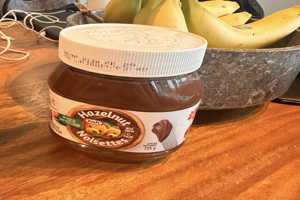

a jar of nutella, a bowl of bananas, and a phone


In [5]:
# Example usage:
blip_chat = BLIP2Chat(width=300, height=200)

# Load an image from a URL or local path
blip_chat.load_image('nutella.jpg')

# Ask a question about the image
answer = blip_chat.ask("Provide a detailed description of the objects in this image")
print(answer)

In [9]:
# Follow-up question
follow_up_answer = blip_chat.ask("What is the main object in this picture")
print(follow_up_answer)

a jar of nutella
